# [without library] <font color="orange">Iris Flower Species Classification using Multiclass Logistic Regression</font>

### Based on - <font color=blue>Stanford CS231n</font> - Softmax classifier - <font color=magenta>Andrej Karpathy</font>, and Cross Entropy Loss Derivative - Roei Bahumi

<img src="../assets/images/iris-multi-logreg/softmax_iris.jpg">

## Introduction

This notebook implements <font color=blue>Multinomial Logistic Regression</font>. It performs <font color=blue>multi-class classification</font> on Iris Flower Species dataset consisting of four attributes and belonging to three classes. There are 300 data points that we divide into training and test data. The prediction accuracy is <font color=blue>94-100%</font>.

Resources:
- [<font color=blue>Stanford CS231n</font> - Softmax classifier - <font color=magenta>Andrej Karpathy</font>](https://cs231n.github.io/linear-classify/#softmax)
- [Cross Entropy Loss Derivative - Roei Bahumi](http://machinelearningmechanic.com/assets/pdfs/cross_entropy_loss_derivative.pdf)
- [Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression - <font color=magenta>Tom Mitchell</font>](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)
- [2020 - <font color=blue>Speech and Language Processing</font> - 3rd EDITION - An Introduction to Natural Language Processing - Computational Linguistics and Speech Recognition - Jurafsky - Martin](https://web.stanford.edu/~jurafsky/slp3/5.pdf)

Towards the end, I have included a <font color=blue>sidebar</font> on the <font color=magenta>Multinomial Logistic Regression</font>. 

## Taxonomy and Notes

Logistic Regression is a <font color=blue>probabilistic</font> classifier. But, it does not model the complete distribution P(X, Y). It is only interested in discriminating among classes. It does that by __computing P(Y \| X) directly__ from the training data. Hence, it is a <font color=blue>probabilistic-discriminative</font> classifier.

__Multinomial Logistic Regression__ is a composition of <font color=blue>K linear functions</font> (K is the number of classes) and the <font color=magenta>softmax</font> function. Softmax is a <font color=blue>generalization of the logistic function</font> to multiple dimensions. It <font color=blue>transforms an N-dimensional feature space to a K-dimensional class space</font>. In the case of Iris Flower Species, the N=5 features (bias + sepal/petal length/width) are mapped to K=3 classes. The weight matrix is (N x K), where each column is a <font color=blue>linear operator</font> w applied on feature vector x.

It is <font color=blue>parametric</font> (weights and bias are the parameters). Binomial Logistic Regression is <font color=blue>binary</font>. The model can be modified to use <font color=magenta>softmax</font> instead of sigmoid, and it becomes <font color=blue>Multiclass</font> Logistic Regression.

In summary, Multinomial Logistic Regression is:
- Probabilistic
- Discriminative
- Binary and Multiclass
- Linear
- Parametric

<img src="../assets/images/log_reg_multi_mmap.png">

## Imports

In [1]:
import numpy as np
import pandas as pd #input
from numpy.random import rand, normal, standard_normal
from numpy import dot, exp
from numpy import mean, std #mean and standard deviation for gaussian probabilities
from scipy.stats import norm #gaussian probabilities
from math import log # to calculate posterior probability
import matplotlib.pyplot as plt
import seaborn as sns

## Data

### Data Configuration (1 of 2)

#### Iris Flower Species

In [1]:
f_data = '../input/iris-species/Iris.csv'
f_cols = ['SepalLengthCm',  'SepalWidthCm',  'PetalLengthCm',  'PetalWidthCm', 'Species']
class_colname = 'Species'

### Read

#### read the csv file

In [3]:
#read the csv file
df = pd.read_csv(f_data)

#### drop unwanted columns

In [4]:
#drop unwanted columns
drop_cols = list(set(df.columns) - set(f_cols))
df = df.drop(drop_cols, axis = 1)

#### rename last column that supposedly has a class/label

In [5]:
#rename the last column to 'class'
cols = df.columns.to_list()
cols[len(cols)-1] = class_colname
df.columns = cols

#### sanity check for data getting loaded

In [6]:
df.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
75,6.6,3.0,4.4,1.4,Iris-versicolor
132,6.4,2.8,5.6,2.2,Iris-virginica
89,5.5,2.5,4.0,1.3,Iris-versicolor
35,5.0,3.2,1.2,0.2,Iris-setosa
103,6.3,2.9,5.6,1.8,Iris-virginica


### Data Preprocessing

#### Helper Functions

##### visualize

In [7]:
def plot_features_violin(data):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    sns.violinplot(data=data, x='Species',y='PetalLengthCm')
    plt.subplot(2,2,2)
    sns.violinplot(data=data, x='Species',y='PetalWidthCm')
    plt.subplot(2,2,3)
    sns.violinplot(data=data, x='Species',y='SepalLengthCm')
    plt.subplot(2,2,4)
    sns.violinplot(data=data, x='Species',y='SepalWidthCm')

##### normalize

In [8]:
'''normalize the features
    
    return:
        copy of the passed in (dataframe), but now with normalized values
        
    parameters:
        df: (dataframe) to normalize
        cols: (list) of columns to normalize
'''
def normalize(df, cols):
    df2 = df.copy(deep = True)
    for col in cols:
        mu = df2[col].mean()
        sigma = df2[col].std()
        df2[col] = (df2[col] - mu) / sigma
        
    return df2

#### Normalize

Before normalization:



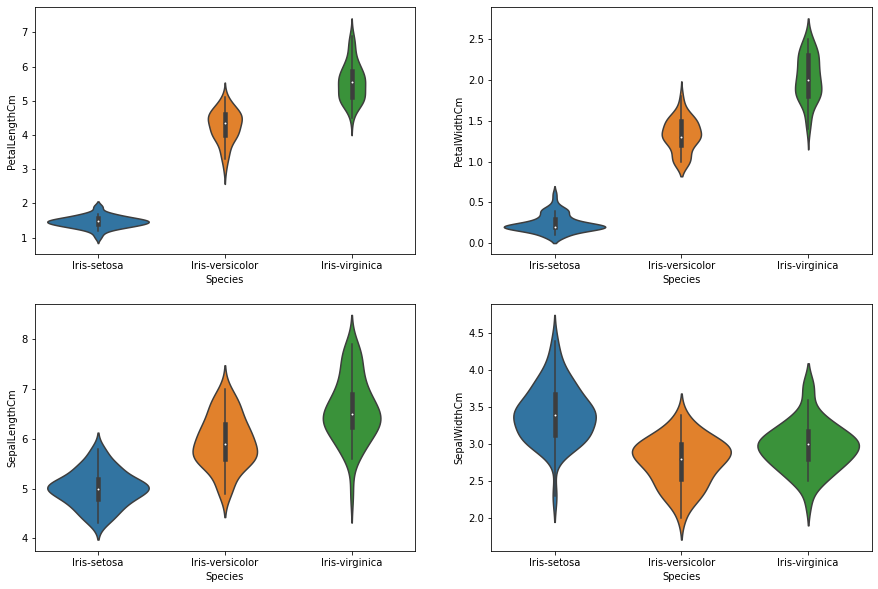

In [9]:
print('Before normalization:\n')
plot_features_violin(df)



After normalization: The relative distribution is still maintained, though the range of values is around 0. (see y-axis markers)



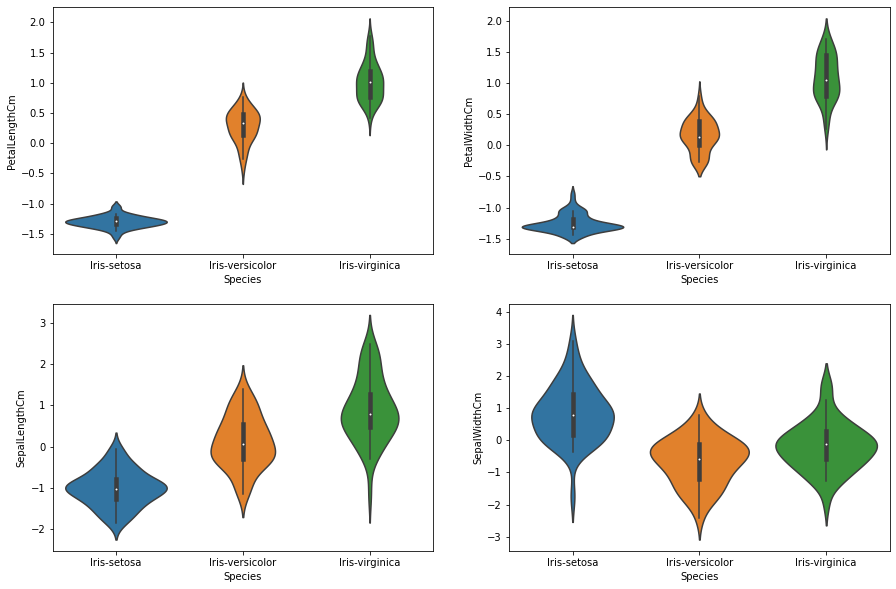

In [10]:
print('\n\nAfter normalization: The relative distribution is still maintained,\
 though the range of values is around 0. (see y-axis markers)\n')
df_norm = normalize(df, f_cols[:-1])
plot_features_violin(df_norm)

### Data Configuration (2 of 2)

#### M: number of data points; N: number of features; K: number of classes

In [11]:
#number of data points, number of attributes
M, N = df_norm.shape[0], df_norm.shape[1]
#number of classes
K = len(df_norm[class_colname].unique())
M, N, K

(150, 5, 3)

#### Class Names

In [12]:
C = df_norm[class_colname].unique()
C

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

#### X_mn, Y

##### X_mn
The data points matrix X_mn is a <font color=blue>M x N</font> matrix, M being the number of data points, N being the number of attributes

In [13]:
#X_mn: first column is the first input '1' for bias
X_mn = np.ones((M, N), dtype=float)
X_mn[:, 1:] = df_norm.loc[:, df_norm.columns != class_colname].to_numpy()
X_mn.shape

(150, 5)

##### Y

In [14]:
#Y: class column
Y = np.array(M, dtype=float)
#encode class name to offset in C: array of class names
Y = [np.where(C == c_name)[0][0] for c_name in (df_norm.loc[:, df_norm.columns == class_colname].to_numpy())]
Y = np.array(Y, dtype=int)
Y.shape

(150,)

## Model

### Model Configuration

In [15]:
loc, scale = 0, 0.1 #to initialize weights
train_ds_percent = 0.8 #to split data into train and test
alpha = 0.001 #learning rate
diff_loss = 0.0001### Model Configuration

### Model Prediction Data Structures

#### W
The weight matrix is an <font color=blue>N x K</font> matrix, N being the number of attributes, and K being the number of classes

In [16]:
#initliaze weights randomly
W_nk = normal(loc = loc, scale = scale, size = (N, K))
W_nk.shape

(5, 3)

### Predict

#### <font color=magenta>softmax</font>

<a href="https://www.codecogs.com/eqnedit.php?latex=q_{i}\left&space;(&space;z&space;\right&space;)=\frac{e^{z_{i}}}{\sum_{j\in&space;\left&space;\{&space;1,..K&space;\right&space;\}}^{}e^{z_{j}}}\;&space;\forall&space;i\in&space;\left&space;\{&space;1,..K&space;\right&space;\}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?q_{i}\left&space;(&space;z&space;\right&space;)=\frac{e^{z_{i}}}{\sum_{j\in&space;\left&space;\{&space;1,..K&space;\right&space;\}}^{}e^{z_{j}}}\;&space;\forall&space;i\in&space;\left&space;\{&space;1,..K&space;\right&space;\}" title="q_{i}\left ( z \right )=\frac{e^{z_{i}}}{\sum_{j\in \left \{ 1,..K \right \}}^{}e^{z_{j}}}\; \forall i\in \left \{ 1,..K \right \}" /></a>

The equation above shows the softmax calculated for element 'i' of the vector Z. Each Z has K elements (K = no. of classes). The function below performs a vector version of softmax, calculating softmax for each element of vector Z and returning the vector of softmax values.

In [17]:
#softmax: normalize each element of Z and return the normalized vector
def softmax_vec(Z):
    # matrix division:
    # numerator: exponentiate each element of Z
    # denominator: exponentiate each element of Z, and then sum them up
    # division: divide each element in the numerator by the sum to normalize it
    return exp(Z) / sum([exp(Z_k) for Z_k in Z])

#### Y_predicted

In [18]:
#predict K probabilities for each data point in 1..M
# and return a M xK matrix of probabilities
def Y_predicted(X_mn, W_nk):
    Z_mk = dot(X_mn, W_nk)
    #each row Z of Z_mk is passed to softmax to normalize it.
    #Y_pred now has a stack of M normalized Z's.
    #Each Z has K elements (K = no. of classes)
    #so, now, for each data point, we have K probabilities,
    # each telling the probability of the data point belonging to class k = 1..K
    Y_pred = np.stack([softmax_vec(Z) for Z in Z_mk])
    return Y_pred # M x K matrix

### Cost (<font color=magenta>cross-entropy loss</font>)(<font color=blue>negative log likelihood loss</font>)

<a href="https://www.codecogs.com/eqnedit.php?latex=H\left&space;(&space;p,&space;q&space;\right&space;)=-\sum_{x}^{}p\left&space;(&space;x&space;\right&space;)\;&space;log&space;\;&space;q\left&space;(&space;x&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?H\left&space;(&space;p,&space;q&space;\right&space;)=-\sum_{x}^{}p\left&space;(&space;x&space;\right&space;)\;&space;log&space;\;&space;q\left&space;(&space;x&space;\right&space;)" title="H\left ( p, q \right )=-\sum_{x}^{}p\left ( x \right )\; log \; q\left ( x \right )" /></a>

In [19]:
'''Cross-Entropy Loss

    returns:
        (float) cross-entropy loss from predictions
        
    parameters:
        Y_pred: (M.K array) (numDataPoints.numClasses) predicted class probabilities for M data points
        Y: (M.1 array) (numDataPoints) actual class for M data points
'''
def Loss_ce(Y_pred, Y):
    L_ce = 0.0
    for m, k in enumerate(Y):
        L_ce += (-1)*log(Y_pred[m][k])
    return L_ce

Loss_ce(Y_predicted(X_mn, W_nk), Y)

168.64146013824276

### Gradient

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\partial&space;l\left&space;(&space;W&space;\right&space;)}{\partial&space;w_{i}}=\sum_{i}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(&space;Y^{l}=1|X^{l},&space;W&space;\right&space;)&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\partial&space;l\left&space;(&space;W&space;\right&space;)}{\partial&space;w_{i}}=\sum_{i}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(&space;Y^{l}=1|X^{l},&space;W&space;\right&space;)&space;\right&space;)" title="\frac{\partial l\left ( W \right )}{\partial w_{i}}=\sum_{i}^{}X_{i}^{l}\left ( Y^{l}-\hat{P}\left ( Y^{l}=1|X^{l}, W \right ) \right )" /></a>

In [20]:
def gradients(X_mn, Y, Y_pred, N, K):
    #gradient along each of the N attributes, for each of the K classes
    grads = np.zeros((N, K), dtype=float)
    for j in range(N):
        for k in range(K):
            for m, X in enumerate(X_mn):
                grads[j][k] += (Y_pred[m][k] - (int)(Y[m]==k))*X[j]

    return grads

gradients(X_mn, Y, Y_predicted(X_mn, W_nk), N, K)

array([[ -0.39155471,   2.19089601,  -1.7993413 ],
       [ 46.39999389,   2.24131206, -48.64130594],
       [-46.75856991,  31.37213789,  15.38643202],
       [ 62.30179774,  -6.00141406, -56.30038368],
       [ 59.5940192 ,  -0.19498116, -59.39903804]])

### Training Algorithm

<a href="https://www.codecogs.com/eqnedit.php?latex=w_{i}\leftarrow&space;w_{i}&plus;\eta&space;\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(&space;Y^{l}=1|X^{l},&space;W&space;\right&space;)&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?w_{i}\leftarrow&space;w_{i}&plus;\eta&space;\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(&space;Y^{l}=1|X^{l},&space;W&space;\right&space;)&space;\right&space;)" title="w_{i}\leftarrow w_{i}+\eta \sum_{l}^{}X_{i}^{l}\left ( Y^{l}-\hat{P}\left ( Y^{l}=1|X^{l}, W \right ) \right )" /></a>

In [21]:
def train(X_mn, Y, W_nk):
    Y_pred = Y_predicted(X_mn, W_nk) #predicted probabilities
    prev_loss = Loss_ce(Y_pred, Y) #loss to begin with
    dLdW = gradients(X_mn, Y, Y_pred, N, K) #gradient along each of the N attributes, for each of the K classes
    W_nk = W_nk - (alpha * dLdW) #apply learning_rate*gradient to the weights
    Y_pred = Y_predicted(X_mn, W_nk) #predicted probabilities with new weights
    new_loss = Loss_ce(Y_pred, Y) #predicted probabilities with new weights
    #summary print
    i_print = 0
 
    #while the loss function is still converging rapidly
    while (prev_loss - new_loss > diff_loss):
        if(i_print % 500) == 0:
            print('Cost:', new_loss)
        prev_loss = new_loss #backup the loss to previous loss for convergence detection
        dLdW = gradients(X_mn, Y, Y_pred, N, K) #gradient along each of the N attributes, for each of the K classes
        W_nk = W_nk - (alpha * dLdW) #apply learning_rate*gradient to the weights
        Y_pred = Y_predicted(X_mn, W_nk) #predicted probabilities with new weights
        new_loss = Loss_ce(Y_pred, Y) #predicted probabilities with new weights
        i_print += 1
        
    return W_nk

### Learn

#### Divide data into Train and Test

In [22]:
mask = rand(M) < train_ds_percent
X_tr, Y_tr, X_te, Y_te = X_mn[mask], Y[mask], X_mn[~mask], Y[~mask]
X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape

((116, 5), (116,), (34, 5), (34,))

#### Learn

In [23]:
W_nk = train(X_tr, Y_tr, W_nk)

Cost: 116.6483283544849
Cost: 18.249658848820356
Cost: 12.951954448719748
Cost: 10.645191711359773
Cost: 9.324411602909944
Cost: 8.452276659013673
Cost: 7.824010517344139
Cost: 7.344201154723735
Cost: 6.962156632256088
Cost: 6.648325577035544
Cost: 6.384245774778408
Cost: 6.157746375601451
Cost: 5.960451836587583
Cost: 5.786392123110191
Cost: 5.6311851365748495
Cost: 5.491533384283073
Cost: 5.36490201563757
Cost: 5.249306026851437
Cost: 5.14316558536557
Cost: 5.045205207521434
Cost: 4.954381949702238
Cost: 4.8698332639541295
Cost: 4.790838471178479
Cost: 4.716789847874346
Cost: 4.647170618675076
Cost: 4.581537988365074
Cost: 4.519509904618752
Cost: 4.460754619121964
Cost: 4.404982373239275
Cost: 4.351938714714369


## Prediction

### Predict

In [24]:
Y_pred_k = [np.argmax(y_pred_k) for y_pred_k in Y_predicted(X_te, W_nk)]

### <font color=magenta>Prediction Accuracy</font>

In [25]:
matches = sum([int(pred==actual) for pred, actual in zip(Y_pred_k, Y_te)])
print('Accuracy is', (matches*100)/len(Y_te), 'percent.')

Accuracy is 94.11764705882354 percent.


## Sidebar - <font color=blue>Multiclass Logistic Regression</font>

### <font color=magenta>Why Softmax?</font>

<img src="../assets/images/iris-multi-logreg/softmax_why.png">

### Why <font color=magenta>linear</font>?

<img src="../assets/images/iris-multi-logreg/softmax_linear.png">

x has unnormalized probabilities, y_cap has normalized probabilities.

### <font color=magenta>Generalization of sigmoid to softmax</font>

<img src="../assets/images/iris-multi-logreg/softmax.png">

### <font color=magenta>Negative Log-Likelihood Loss</font>

<img src="../assets/images/iris-multi-logreg/multi_logreg_neg_log_like_loss.png">

### <font color=magenta>Derivation of Eq.5.37</font> (gradient for a single example)

<img src="../assets/images/iris-multi-logreg/notebook_notes.jpg">